In [1]:
import numpy as np
import pandas as pd

import pymc as pm
from scipy.stats import halfnorm

import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az


# Bayesian Data Analysis: USA College Completion Analysis
DS&AI: 3rd year's Semestral project

*   Georgiy Farina: georgiy.farina@student.supsi.ch
*   Enkh-Oyu Nomin: enkhoyu.nomin@student.supsi.ch

## Description of data and exploratory analysis

The chosen <a href="https://www.kaggle.com/datasets/thedevastator/boost-student-success-with-college-completion-da?select=cc_institution_details.csv">dataset</a> contains records of various data related to USA colleges/universities. There are more than 60 columns present between categorical information and numerical statistics.

The required tasks to be done for the following project are as follows:
- At least one hypothesis test for each student, discussing:
    - the choice of the prior and likelihood;
    - convergence diagnostics;
    - prior sensitivity (i.e., re-run with a different and reasonable prior);
    - posterior predictive checks;
    - conclusions based on the posterior, including a meaningful definition of rope.

- At least a hierarchical model presenting:
    - the choice of the prior and likelihood;
    - the **posterior distribution of the mean** for a specific group;
    - the **predictive distribution for the same group**, i.e., the probability distribution for a future measure for that group. The predictive distribution has to be computed by a cycle implemented by you, without using pymc3 functions such as sample_posterior_predictive
    - the posterior distribution of a novel group, for which there are currently not yet observation(for instance, a hospital not yet included in the trial).

- At least a regression model including:
    - choice of prior and likelihood
    - convergence diagnostics
    - predictive distribution for an observation of the test set.

What we decided to focus on from the dataset are the following two information:
* Graduation rate: represented by two features, _grad_100_value_ and _grad_150_value_, respectively containing the percentage of students that completed the institution within either 100% or 150% of "normal" graduation time. The one we decide to use is the 150 one.
* SAT score connection to graduation rate: the dataset contains a column called _med_sat_value_ which represents the median SAT score of the institution

In [2]:
df = pd.read_csv('cc_institution_details.csv').drop(columns=['index'])
df.head()

,unitid,chronname,city,state,level,control,basic,hbcu,flagship,long_x,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,-86.568502,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,-86.809170,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,-86.174010,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,-86.638420,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,-86.295677,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [3]:
df.shape

(3798, 62)

As mentioned already, what we wanted to keep as information are the college's name, state, graduation rate and the median SAT score. For this reason we created another dataframe containing only the neccessary data.

In [4]:
partial_df = df[['chronname', 'state', 'grad_150_value',
                  'med_sat_value']]
partial_df.shape

(3798, 4)

At first we checked the presence of null values. Since there are several tasks that require either one variable both, for tasks that require graduation rate, we will drop only those rows keeping also the ones where the median SAT value is null, whereas when the latter will be needed (for the regression model), we will also drop the rows having null values of SAT. We decided not to impute the data since it is real colleges data that we analyze, therefore imputing those data based on a variety of information that differ such as state, city and so on, we decided to just drop those rows (having also a substantial amount of rows even after elimination)

In [5]:
print(partial_df.isnull().sum())
print('-'*50)
print(round((partial_df.isnull().sum() / partial_df.shape[0])*100, 2))

chronname            0
state                0
grad_150_value     331
med_sat_value     2461
dtype: int64
--------------------------------------------------
chronname          0.00
state              0.00
grad_150_value     8.72
med_sat_value     64.80
dtype: float64


In [6]:
grad_150_df = partial_df.dropna(subset=['grad_150_value'])
print("After removing null values of grad_150_value: ", grad_150_df.shape)

median_sat_values_df = grad_150_df.dropna(subset=['med_sat_value'])
print("After removing null values of both grad_150_value and med_sat_value: ", median_sat_values_df.shape)

After removing null values of grad_150_value:  (3467, 4)
After removing null values of both grad_150_value and med_sat_value:  (1319, 4)


Since we want to analyze the states, we remove District of Columbia from the dataset and we'll consider only the records from the official states

In [7]:
grad_150_df = grad_150_df[grad_150_df['state'] != 'District of Columbia']

Below the counts for each state, in order to understand for further analysis, how many samples are available for the Hierarchical modelling part. Except for a few, all the states have a sufficient amount of observable data which can be used for eventual sampling and so on.

<Axes: >

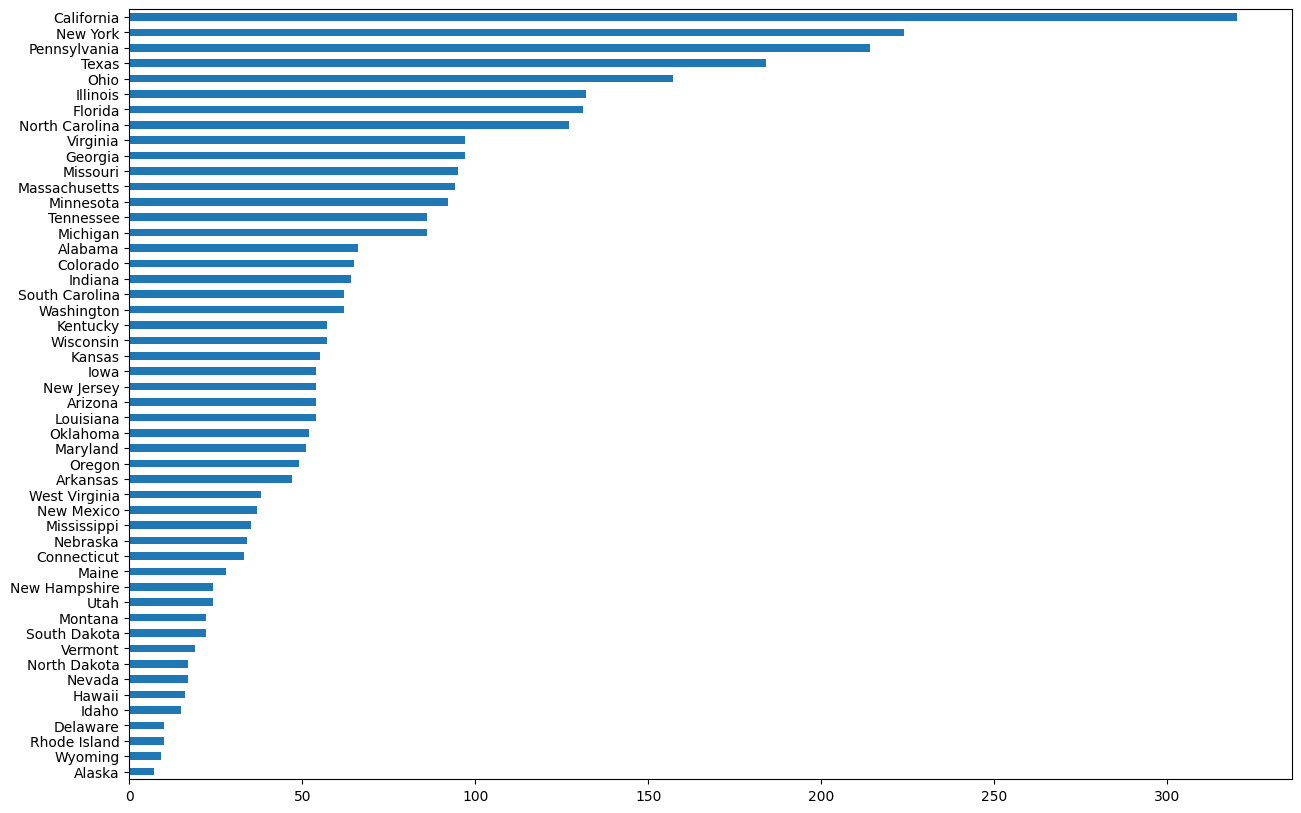

In [8]:
plt.figure(figsize=(15, 10))
state_counts = grad_150_df['state'].value_counts().sort_values(ascending=True)
state_counts.plot(kind='barh')

For the same reasons as above, we decided to plot the scatter plot for the two numerical variables of graduation and median SAT score. It can be clearly seen that the correlation is pretty strong, therefore we expect to be able to model properly this relation and being able to predict well testing data.

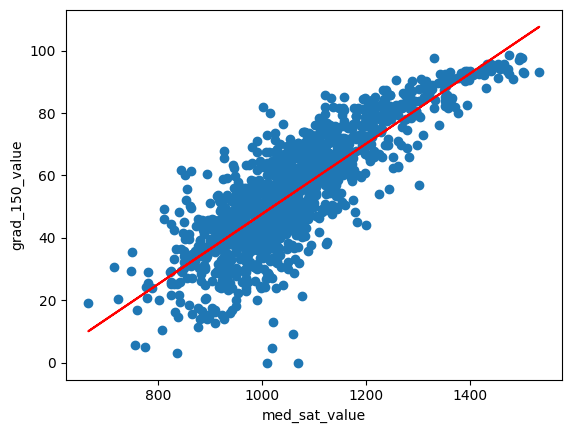

In [9]:
med_sat_values = median_sat_values_df['med_sat_value'].values
grad_values = median_sat_values_df['grad_150_value'].values

plt.scatter(med_sat_values, grad_values)

m, b = np.polyfit(med_sat_values, grad_values, 1)
plt.plot(med_sat_values, m*med_sat_values + b, color='red')

plt.xlabel('med_sat_value')
plt.ylabel('grad_150_value')

plt.show()

## Hypothesis test: Graduation rate between New York and California

During a brief exploratory analysis performed beforehand, we noticed that New York and California are the two states with the highest number of samples, therefore we decided that it would be a meaningful comparison considering that the model would be pretty robust. By means of a 2 sample hypothesis test, we want to compare if there is a significant difference between the graduation rate withing the two states.<br>
In order to do so, we perform a hypothesis t-test formulated as:
\begin{align*}
H_0: \; & \mu_{\text{new-york}} = \mu_{\text{california}} \\
H_1: \; & \mu_{\text{new-york}} \neq \mu_{\text{california}}
\end{align*}

In [10]:
newyork_data = grad_150_df[grad_150_df['state'] == 'New York']
california_data = grad_150_df[grad_150_df['state'] == 'California']

### Choice of prior and likelihood

#### Prior for $\mu_{\text{new-york}}$ and $\mu_{\text{california}}$

As per <a href="https://nscresearchcenter.org/completing-college/">national reports</a>, we can assume the mean graduation rate in the USA to revolve around 55%, with standard deviation that can be chosen around 7.5 since there are states that get to just 40% and others that can get up to 70%. We will setup our prior believes on these data.

The mean graduation rate of the population lies in (40, 70); we interpret this as an interval of +-2$\sigma$. We will be assigning the same prior to both the states, so that neither one will be fabored over another

$$
\mu_{\text{new-york}}   \sim  N (55, 7.5 )
$$
$$
\mu_{\text{california}}   \sim  N (55, 7.5 )
$$

#### Prior for $\sigma_{\text{new-york}}$ and $\sigma_{\text{california}}$

Assuming the same standard deviation for both the states,  we tune the half-normal prior in order to get a median close to the std value, being 7.5. The value we obtained is 11

$$\sigma_{\text{new-york}} \sim HN(11)$$
$$\sigma_{\text{california}} \sim HN(11)$$

In [11]:
pd.DataFrame(halfnorm.rvs(scale=11, size=10000)).describe()

,0
count,10000.000000
mean,8.827791
std,6.695193
min,0.005882
25%,3.477595
50%,7.394744
75%,12.885716
max,43.506226


#### Likelihood

* Assuming a Gaussian distribution of the observations we have the following priors, where the parameters of the two distributions are the priors we defined above
$$\vec{y}_{new-york} \sim N(\mu_{\text{new-york}}, \sigma_{\text{new-york}})$$

$$\vec{y}_{california} \sim N(\mu_{\text{california}}, \sigma_{\text{california}})$$
* By means of this we already created the first layer of the hierarchy information sharing, where we model a lower level information with the knowledge about a higher level prior.
* In this case vector notation is used to make it clear that there are array of measures, and not just one single observation. These vectors represent the data of New York and California

* With this, we can build the full probabilistic model by combining prior and likelihood in the following way:

\begin{align*}
\mu_{\text{new-york}} & \sim N(55, 7.5) \\
\sigma_{\text{new-york}} & \sim HN(11) \\
\vec{y}_{\text{new-york}}  & \sim N(\mu_{\text{new-york}}, \sigma_{\text{new-york}}) \\
\\
\mu_{\text{california}} & \sim N(55, 7.5) \\
\sigma_{\text{california}} & \sim HN(11) \\
\vec{y}_{\text{california}}  & \sim N(\mu_{\text{california}}, \sigma_{\text{california}})\\
\end{align*}

### Model

* Having now the complete information about how the data are assumed to be distributed and which distributions do they follow, we can implement the model using the pymc3 library.
* In order to see if there is proof of significant difference between the mean rates of the two states involved, the difference itself needs to be computed, which can be done on pymc using a _Deterministic_ variable, because it can be considered as a deterministic function of two different variables/parameters.
$$\mu_{\text{new-york}} - \mu_{\text{california}}$$

* The information regarding this deterministic difference will be stored in the computed trace

In [12]:
# Our defined priors
if os.path.exists('trace_ht_1_correct_prior.nc'):
    trace_ht_1_correct_prior = az.from_netcdf('trace_ht_1_correct_prior.nc')
else:
    with pm.Model() as model_ht_1_correct_prior:
        # Priors
        mu_newyork         = pm.Normal     ('mu_newyork',  mu = 55,  sigma = 7.5)
        mu_california      = pm.Normal     ('mu_california', mu = 55,  sigma = 7.5)
        sigma_newyork      = pm.HalfNormal ('sigma_newyork',  sigma=11)
        sigma_california   = pm.HalfNormal ('sigma_california', sigma=11)

        # Likelihood
        y_newyork = pm.Normal  ('y_new_york',  mu=mu_newyork,      sigma=sigma_newyork,       observed=newyork_data['grad_150_value'])
        y_california = pm.Normal  ('y_california',  mu=mu_california, sigma=sigma_california, observed= california_data['grad_150_value'])

        diff_of_means = pm.Deterministic ('diff_of_means', mu_newyork - mu_california)

        trace_ht_1_correct_prior   = pm.sample(return_inferencedata=True)
        az.to_netcdf(trace_ht_1_correct_prior, 'trace_ht_1_correct_prior.nc')

### Convergence diagnostics

In order to understand the convergence of our model or a lack of, we can analyze some factors available from the trace such as:
- Density plots: the various lines that can be seen from the leften side of the plot are smooth and converging towards the same bell-shaped distributions, indicating a good convergence
- Trace plots: the righten side of the plot shows the values that were samples throughout the time. There is a good converence if these resemble "fuzzy caterpillars", which they do. If there were some predisposition towards oversampling some values and ignoring others, it woudl've been a problem, but here the situation seems to be adequate
- r_hat: the closer they are to 1, the better the convergence is. In our case all the values are exactly 1, confirming convergence once again
- ess_bulk / ess_tail: representing the effective sample size for the bulk and the tail of the distribution, these values can tell us about the chain exploration of the posterior space. If these two numbers are high, it means that the model was able to explore succesfully the whole posterior space, as is our case

The values for mean and standard deviation of the various parameters are pretty lower than expected, but that didn't influence much the finalr results.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


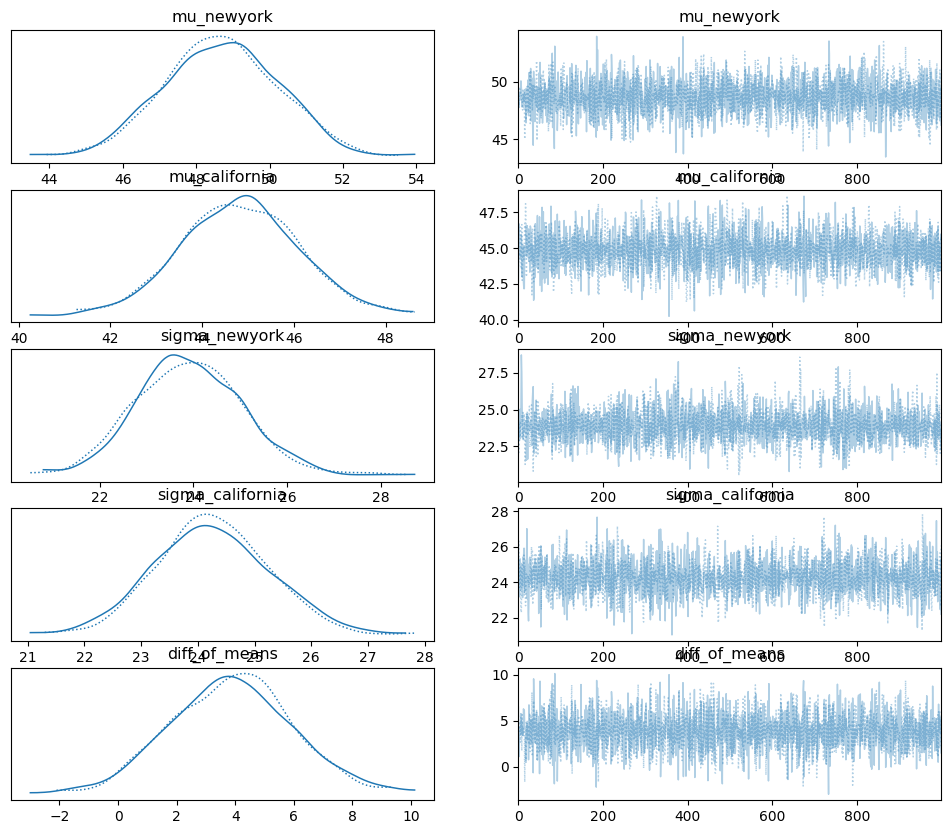

In [13]:
az.plot_trace(trace_ht_1_correct_prior);

In [14]:
az.summary(trace_ht_1_correct_prior, hdi_prob=0.95)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_newyork,48.686,1.561,45.527,51.467,0.026,0.018,3680.0,1660.0,1.0
mu_california,44.826,1.287,42.115,47.180,0.022,0.016,3405.0,1491.0,1.0
sigma_newyork,23.926,1.138,21.731,26.099,0.019,0.014,3646.0,1450.0,1.0
sigma_california,24.259,1.001,22.289,26.138,0.017,0.012,3301.0,1630.0,1.0
diff_of_means,3.860,2.057,0.137,7.941,0.032,0.025,4167.0,1640.0,1.0


### Prior sensitivity

In Bayesian analysis the prior is an important part of the model, and choosing wrong priors can destabilize the model making it not converge, therefore weak. To understand the sensitivity of the model towards the prior choice, we decided to choose other values of the prior. These values have a higher mean for the two states, but also a higher sigma, allowing values of the mean to range from 40 to 80.

By doing so we confirmed the model's ability to converge, analyzing the plots of the trace and the summary dataframe.
* Densities for the 5 parameters end up towards the same shape and mean values, with the different chains overlapping one on another
* The traces show the homogeneous sampling of the same range of data, with no evident peaks or drifts
* r_hat values are all equal to 1, as before
* High values of ess_bulk and ess_tail are indicating good space exploration

In [15]:
# Checking for prior sensitivity by assuming a pretty different priors
if os.path.exists('trace_ht_1_different_prior.nc'):
    trace_ht_1_different_prior = az.from_netcdf('trace_ht_1_different_prior.nc')
else:
    with pm.Model() as model_ht_1_different_prior:
        mu_newyork         = pm.Normal     ('mu_newyork',  mu = 60,  sigma = 10)
        mu_california      = pm.Normal     ('mu_california', mu = 60,  sigma = 10)
        sigma_newyork      = pm.HalfNormal ('sigma_newyork',  sigma=25)
        sigma_california   = pm.HalfNormal ('sigma_california', sigma=25)


        y_newyork = pm.Normal  ('y_new_york',  mu=mu_newyork,      sigma=sigma_newyork,       observed=newyork_data['grad_150_value'])
        y_california = pm.Normal  ('y_california',  mu=mu_california, sigma=sigma_california, observed= california_data['grad_150_value'])

        diff_of_means = pm.Deterministic ('diff_of_means', mu_newyork - mu_california)

        trace_ht_1_different_prior   = pm.sample(return_inferencedata=True)
        az.to_netcdf(trace_ht_1_different_prior, 'trace_ht_1_different_prior.nc')

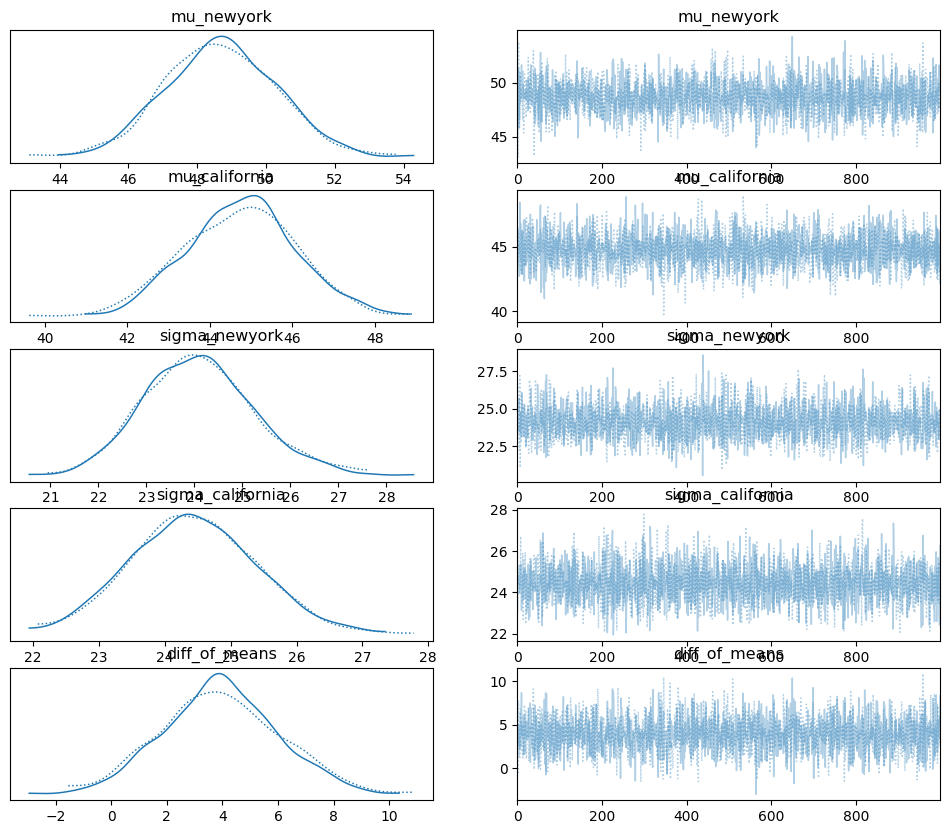

In [16]:
az.plot_trace(trace_ht_1_different_prior);

In [17]:
az.summary(trace_ht_1_different_prior, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_newyork,48.680,1.599,45.623,51.867,0.029,0.021,2975.0,1601.0,1.0
mu_california,44.754,1.329,42.301,47.447,0.024,0.017,3131.0,1417.0,1.0
sigma_newyork,24.099,1.142,21.900,26.425,0.020,0.014,3264.0,1585.0,1.0
sigma_california,24.442,0.951,22.618,26.304,0.016,0.011,3677.0,1746.0,1.0
diff_of_means,3.926,2.072,-0.132,7.880,0.037,0.029,3134.0,1571.0,1.0


### Posterior predictive check

To have a visual check of the posterior distribution with respect to the observed data, we can plot the together by sampling from the trace's posterior. In order to do this, we used the function given by PYMC called sample_posterior_predictive
From the plots below, the following can be concluded:
- The density in the bulk and tail region reflects the one shown by the observed data
- The distributions of the observed data for both New York and California appear to be two modal in the center, New York a bit less and California a bit more. This doesn't impact though on the final results, being those distributions approximated pretty well
- There is no need to take the Robust Likelihood approach, the one less sensitive to the outliers, since our outliers outside of the +-2$\sigma$ range are still captured

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


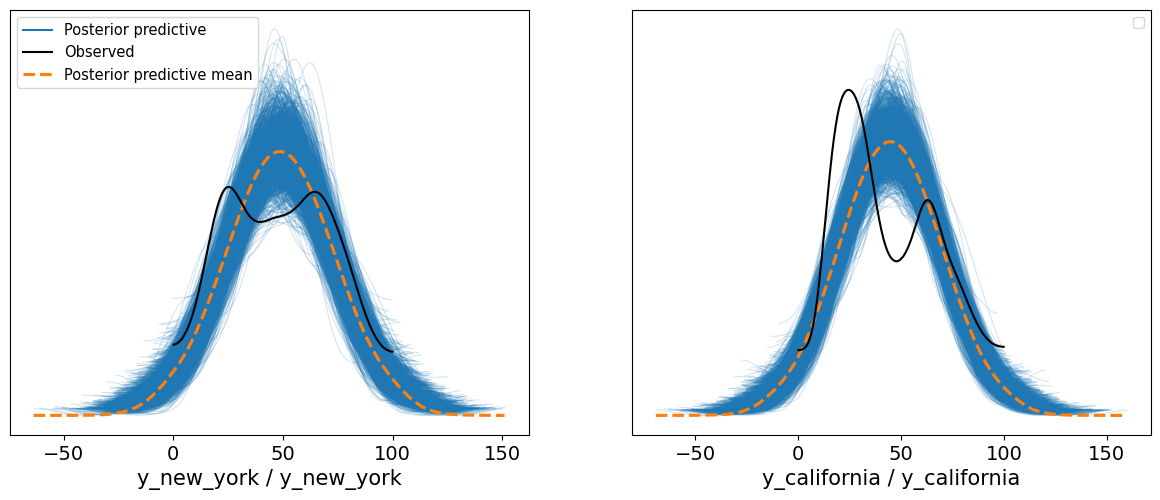

In [18]:
if not os.path.exists("trace_ht_1_correct_prior"):
  with model_ht_1_different_prior:
      ppc = pm.sample_posterior_predictive(trace_ht_1_correct_prior)
  az.plot_ppc(ppc);

### Conclusions based on posterior, including a meaningful definition of ROPE

Now the question we got to ask ourselves is whether the 0 difference mean between the two states is plausible with our data or not. To do so, we need to check if 0 lies on the 95% High Density Interval, which it does in this case but its at the very limit, indicating that H0 could likely be rejected, proving the mean between New York and California being different

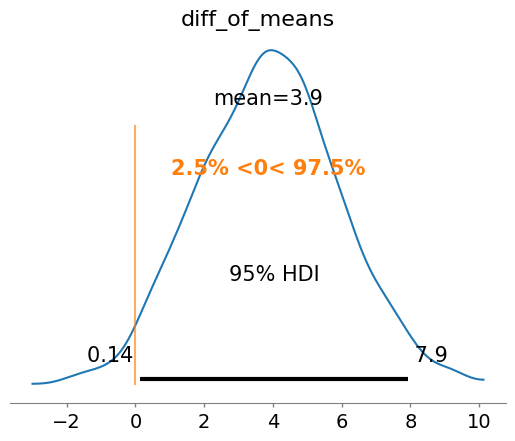

In [19]:
az.plot_posterior(trace_ht_1_correct_prior,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

In the plot below we can see how the difference of means falls withing our ROPE indicator. This tells us the region (in this case, between -1 and 1) in which the difference between the two groups is insignificant. The more our difference mean falls within the ROPE, the more we can exclude any significant difference between the two groups. <br>
The mean difference between the two states is of 3.9 The HDI includes the zero by very little, almost insignificantly, and the percentage of the posterior distribution within the ROPE (Range of Practical Equivalence) is 7.3%, suggesting that the difference is practically significant and that we can fairly conclude that there is a solid difference between the graduation rate of the two states

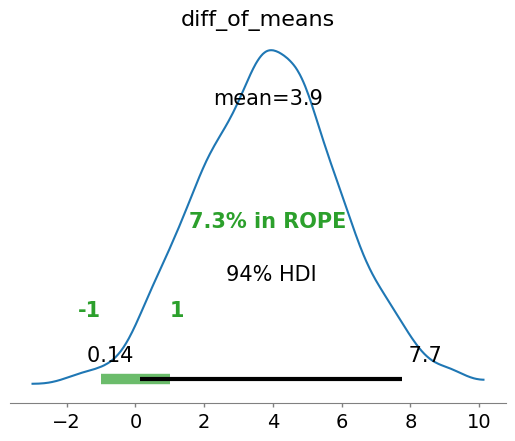

In [20]:
az.plot_posterior(trace_ht_1_correct_prior, var_names="diff_of_means", rope=[-1,1]);

Another way to interpret the results of the difference of means analysis is to compute the probabilities, over the samples of the posterior, of the difference being either around 0 or significantly lower greater than the ROPE range.<br>
From the results we got here we c
an estabilish that there is:
- 91.7% probability of the difference being greater significantly greater than 1. This means that in 91.7% of the posterior samples, the graduation rate of New-York was better than the California one by at least 1%
- 7.4% (as the percentage of the posterior being in the ROPE) probability of the difference being around 0
- 0.9% probability of the difference being less than 1, meaning the porbability that a California college would have a greater graduation rate than a New York one by at least 1%

In [21]:
samples                  = az.extract(trace_ht_1_correct_prior)
diff_samples             = samples.diff_of_means.values
p_significant_positive   = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative   = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq         = 1 - p_significant_negative - p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.916
p_practically_eq:  0.074
p_significant_negative:  0.011


Based on the whole analysis performed, we can be reasonably confident in saying that the difference in graduation rate between New York and California is significantly different, having New York coming out on top with respect to California.

## Hypothesis test: Difference in Graduation between Western and Eastern States

In history there were many rivalries between the two coasts of America: the Western laying on the Pacific Ocean, and the Eastern touching the Atlantic one. Among these rivalries, we thought of one in particular: aren't some of the best universities in the Eastern coast of USA? Among those are present such universities as Harvard, Stanford, Cambridge just to cite a few. With that in mind, we discussed about what we would expect the best coast to be in terms of graduation rate, and we arrived at the hypothesis of the Eastern coast graduating more frequently.

Formalizing the hypothesis, it would be:
\begin{align*}
H_0: \; & \mu_{\text{east}} \le \mu_{\text{west}} \\
H_1: \; & \mu_{\text{east}} \gt \mu_{\text{west}}
\end{align*}

At first we split the dataset in two, one for each coast

In [22]:
eastern_states = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey',
'Delaware', 'Maryland', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida',
'Kentucky', 'Tennessee', 'Ohio', 'Indiana', 'Michigan', 'Wisconsin', 'Illinois', 'Alabama']

eastern_df = grad_150_df[grad_150_df['state'].isin(eastern_states)]
western_df = grad_150_df[~grad_150_df['state'].isin(eastern_states)]

### Choice of prior and likelihood

#### Prior for $\mu_{\text{east}}$ and $\mu_{\text{west}}$

We decided for the prior concerning the mean of a certain coast to keep the same ones as previously stated, but we'll consider a smaller standard deviation since, having more data from different states, makes us except a smaller variation in the mean.

$$
\mu_{\text{east}}   \sim  N (55, 5 )
$$
$$
\mu_{\text{west}}   \sim  N (55, 5 )
$$

#### Prior for $\sigma_{\text{east}}$ and $\sigma_{\text{west}}$

As above, we decided to keep the same standard deviation for the two means. To simulate it through the HalfNormal distribution, we tune the half-normal prior in order to get a median close to 5. The value we got is 7.5

$$\sigma_{\text{east}} \sim HN(7.5)$$
$$\sigma_{\text{west}} \sim HN(7.5)$$

In [23]:
pd.DataFrame(halfnorm.rvs(scale=7.5, size=10000)).describe()

,0
count,10000.000000
mean,6.051701
std,4.571954
min,0.000389
25%,2.400086
50%,5.130666
75%,8.692258
max,30.207031


#### Likelihood

* Like before, we assumed the distributions of the means for both the coasts to follow a Normal distribution, with the parameters of $\mu$ and $\sigma$ being the priors we defined before
$$\vec{y}_{east} \sim N(\mu_{\text{east}}, \sigma_{\text{east}})$$

$$\vec{y}_{west} \sim N(\mu_{\text{west}}, \sigma_{\text{west}})$$

* With the whole prior and likelihood ready, we can build the new probabilistic model to represent easter and western data

\begin{align*}
\mu_{\text{east}} & \sim N(55, 5) \\
\sigma_{\text{east}} & \sim HN(7.5) \\
\vec{y}_{\text{east}}  & \sim N(\mu_{\text{east}}, \sigma_{\text{east}}) \\
\\
\mu_{\text{west}} & \sim N(55, 5) \\
\sigma_{\text{west}} & \sim HN(7.5) \\
\vec{y}_{\text{west}}  & \sim N(\mu_{\text{west}}, \sigma_{\text{west}})\\
\end{align*}

#### Model

* As before, in order to compute the hypothes test later one, we need a _Deterministic_ variable, representing the difference between the two means.
$$\mu_{\text{east}} - \mu_{\text{west}}$$

* The information regarding this deterministic difference will be stored in the computed trace

In [24]:
# Our defined priors
if os.path.exists('trace_ht_2_correct_prior.nc'):
    trace_ht_2_correct_prior = az.from_netcdf('trace_ht_2_correct_prior.nc')
else:
    with pm.Model() as model_initial_prior:
        mu_east         = pm.Normal     ('mu_east',  mu = 55,  sigma = 5)
        mu_west      = pm.Normal     ('mu_west', mu = 55,  sigma = 5)
        sigma_east      = pm.HalfNormal ('sigma_east',  sigma=7.5)
        sigma_west   = pm.HalfNormal ('sigma_west', sigma=7.5)

        y_east = pm.Normal  ('y_east',  mu=mu_east,      sigma=sigma_east,       observed=eastern_df['grad_150_value'])
        y_west = pm.Normal  ('y_west',  mu=mu_west, sigma=sigma_west, observed= western_df['grad_150_value'])

        diff_of_means = pm.Deterministic ('diff_of_means', mu_east - mu_west)

        trace_ht_2_correct_prior   = pm.sample(return_inferencedata=True)
        az.to_netcdf(trace_ht_2_correct_prior, 'trace_ht_2_correct_prior.nc')

### Convergence diagnostics

To check for convergence, we did as before, meaning analyzing the following aspects:
- Density plots: the sampling chains are converging as before, forming a Gaussian-like distribution
- Trace plots: the sampling frequencies are distributed evenly and correctly around the mean
- r_hat: as before, all values of r_hat are equal to 1, indicating convergence
- ess_bulk / ess_tail: showing a high amount for both, these two parameters confirm ulteriorly convergence

As before, we overestimated

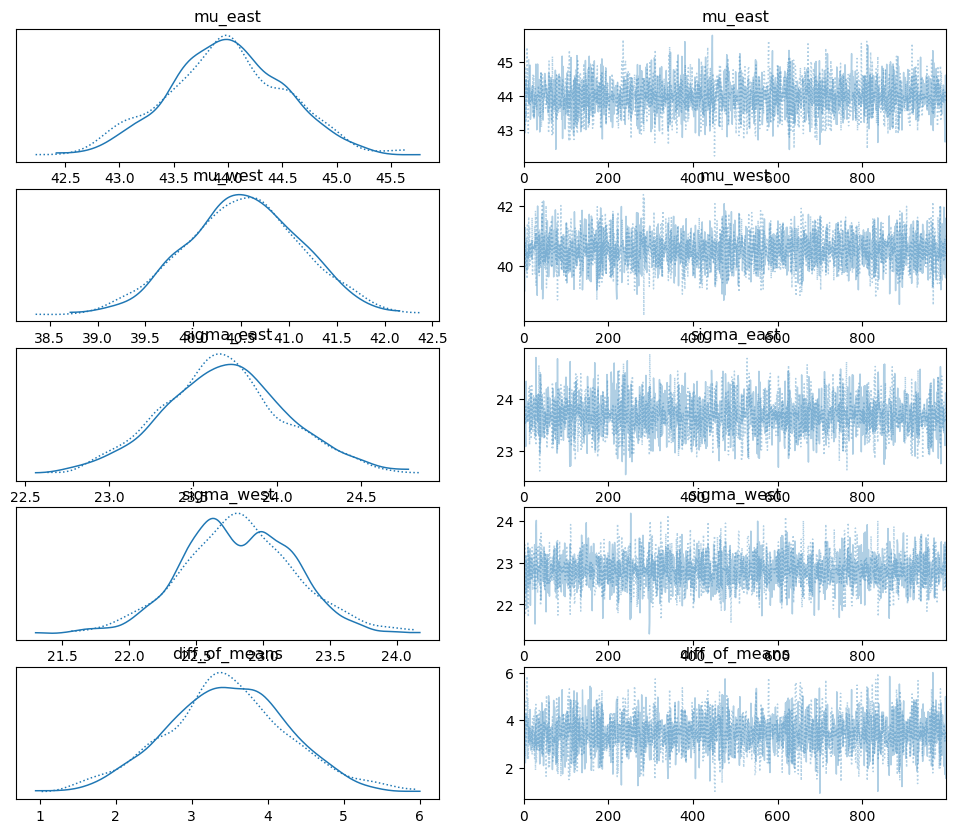

In [25]:
az.plot_trace(trace_ht_2_correct_prior);

In [26]:
az.summary(trace_ht_2_correct_prior, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_east,43.987,0.548,42.926,45.046,0.008,0.006,4128.0,1725.0,1.0
mu_west,40.521,0.603,39.312,41.664,0.009,0.006,4599.0,1680.0,1.0
sigma_east,23.689,0.373,22.997,24.486,0.006,0.005,3415.0,1786.0,1.0
sigma_west,22.816,0.419,21.968,23.622,0.008,0.005,3081.0,1454.0,1.0
diff_of_means,3.467,0.815,1.717,4.945,0.012,0.009,4396.0,1549.0,1.0


### Prior sensitivity

In the previous HT we noticed that choosing different, but still reasonable priors, didn't affect the posterior sampling and distributions. We except the same behaviour also for this hypothesis test, but we still want to check if that is indeed the case.

We chose priors that were agian reasonable for this problem. We decided to apply changes only to the mean parameter of the two $\mu$ parameters, raising the one of the eastern distribution and lowering the western one, both by 5.

Even with these priors, the two groups are able to converge in the same bell-shaped distributions, the "fuzzy caterpillar" appeared the same again, and the summary variables such as r_hat and ess_bulk / ess_tail are all showing good results of model convergence

In [27]:
# Our defined priors
if os.path.exists('trace_ht_2_different_prior.nc'):
    trace_ht_2_different_prior = az.from_netcdf('trace_ht_2_different_prior.nc')
else:
    with pm.Model() as model_initial_prior:
        mu_east         = pm.Normal     ('mu_east',  mu = 65,  sigma = 5)
        mu_west      = pm.Normal     ('mu_west', mu = 50,  sigma = 5)
        sigma_east      = pm.HalfNormal ('sigma_east',  sigma=7.5)
        sigma_west   = pm.HalfNormal ('sigma_west', sigma=7.5)

        y_east = pm.Normal  ('y_east',  mu=mu_east,      sigma=sigma_east,       observed=eastern_df['grad_150_value'])
        y_west = pm.Normal  ('y_west',  mu=mu_west, sigma=sigma_west, observed= western_df['grad_150_value'])

        diff_of_means = pm.Deterministic ('diff_of_means', mu_east - mu_west)

        trace_ht_2_different_prior   = pm.sample(return_inferencedata=True)
        az.to_netcdf(trace_ht_2_different_prior, 'trace_ht_2_different_prior.nc')

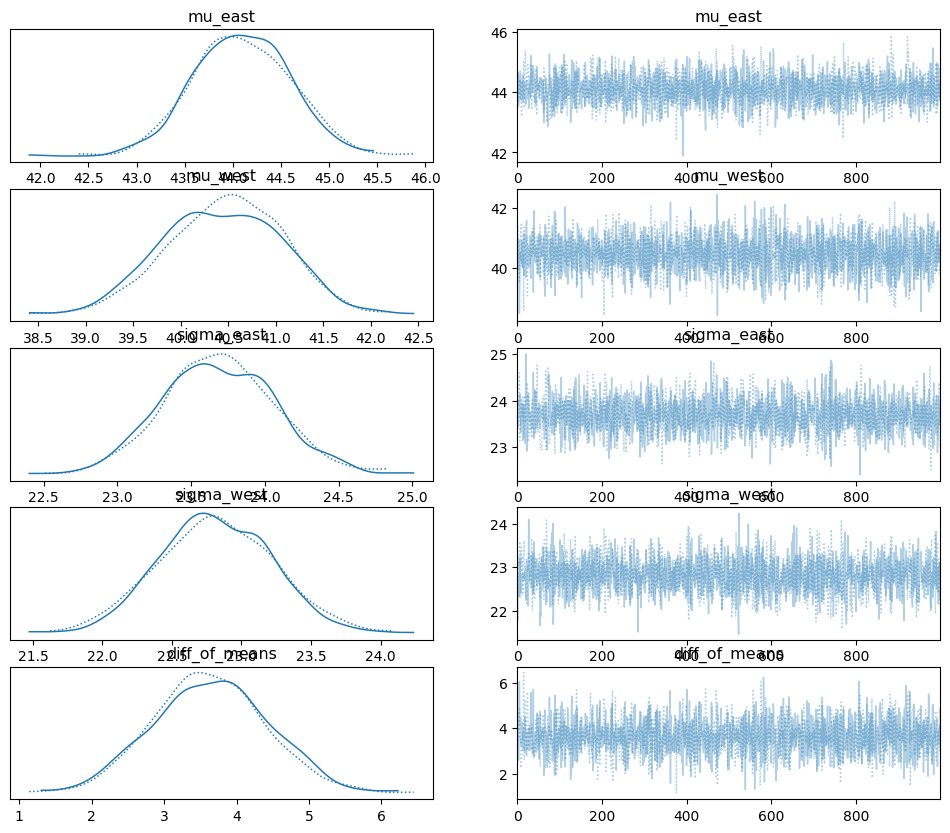

In [28]:
az.plot_trace(trace_ht_2_different_prior);

In [29]:
az.summary(trace_ht_2_different_prior, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_east,44.095,0.497,43.121,45.036,0.009,0.007,2922.0,1710.0,1.0
mu_west,40.458,0.618,39.250,41.578,0.010,0.007,4180.0,1852.0,1.0
sigma_east,23.688,0.376,22.935,24.401,0.007,0.005,2767.0,1394.0,1.0
sigma_west,22.815,0.410,21.981,23.575,0.008,0.006,2614.0,1416.0,1.0
diff_of_means,3.637,0.783,2.109,5.070,0.013,0.010,3543.0,1968.0,1.0


### Posterior predictive check

After sampling, the posterior needs to be checked, same as before, to be two modal in the center, New York a bit less and California a bit more. This doesn't impact though on the final results, being those distributions approximated pretty well
- There is no need to take the Robust Likelihood approach, the one less sensitive to the outliers, since our outliers outside of the +-2$\sigma$ range are still captured

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


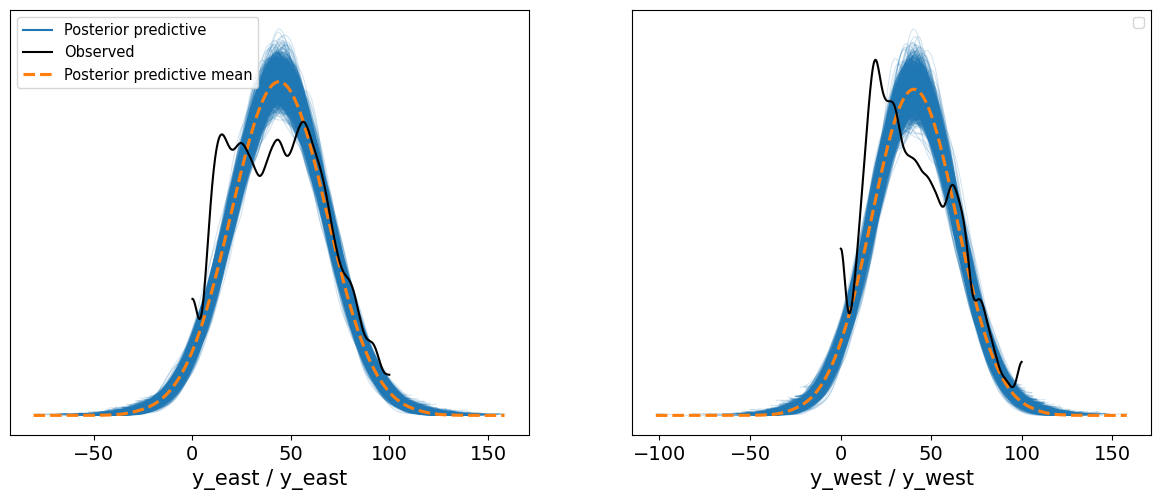

In [30]:
if not os.path.exists("trace_ht_2_correct_prior"):
  with model_initial_prior:
      ppc = pm.sample_posterior_predictive(trace_ht_2_correct_prior)
  az.plot_ppc(ppc);

### Conclusions based on posterior, including a meaningful definition of ROPE

To check the hypothesis possible result, a possible indication is to see if the reference value of 0 is in the HDI, which is not, in fact its way out far from the distribution itself, which does not include it as value

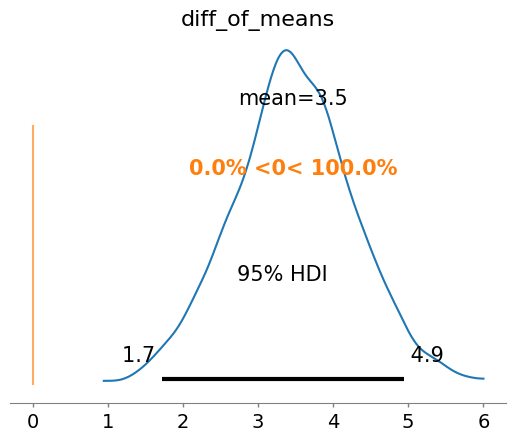

In [31]:
az.plot_posterior(trace_ht_2_correct_prior,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

We may observe how the mean difference falls within our ROPE indicator in the plot below. This indicates the range (in this case, -1 to 1) in which there is little variation between the two groups. We can rule out any meaningful difference between the two groups the more our difference mean lies inside the ROPE. <br>
The mean difference between the two states is of 3.4 The ROPE range overlaps with the HDI by just 0.1%, makin us understand very clearly that the two means are far away one from another

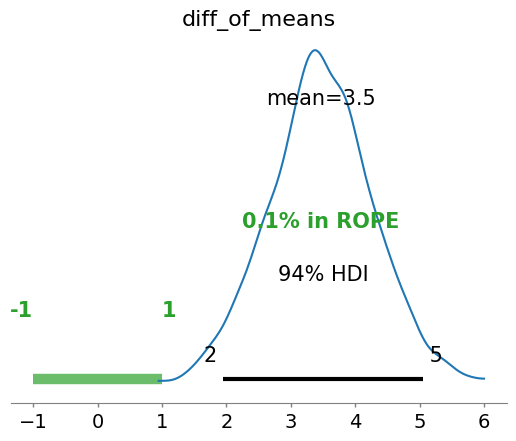

In [32]:
az.plot_posterior(trace_ht_2_correct_prior, var_names="diff_of_means", rope=[-1,1]);

Calculating the probability over the posterior samples of the difference being either around 0 or much smaller than the ROPE range is another method to evaluate the results of the difference of means study.<br>
From the results we got here we can estabilish that there is not a chance that the mean of the Western states is bigger than the one of the Eastern states, therefore we can succesfully reject H0 and accept H1.

In [33]:
samples                  = az.extract(trace_ht_2_correct_prior)
diff_samples             = samples.diff_of_means.values
p_significant_positive   = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative   = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq         = 1 - p_significant_negative - p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  1.000
p_practically_eq:  0.000
p_significant_negative:  0.000


## Hierarchical model

### Choice of prior and likelihood
Having the nature of the model to be hierarchical, the setting of prior comes from defining a prior for each smallest group (in this case, for each state), where that prior is believed to come from a broader distribution that captures overall trends across states.

* The $j$ subscript refers to the $j$-th state (we have 50 states).

*  $n_j$: number of colleges present in the state $j$.

*  $y_{ij}$: number of students who graduated within 150% of the normal time from the $i$-th college of a state $j$
    * $j \in \{1,2,…,50\}$, $i \in \{1,2,…,n_j\}$.

* State $j$ has its own mean graduation rate of colleges, $\mu_j$   

The full probabilistic model is composed of several parts which include:
* Prior beliefs about the graduation rate of the states in the population
* Distributions representing:
  - Graduation rate of a particular state $j$
  - Graduation rate of a particular college $y_{ij}$

\begin{equation}
\begin{array}{lrl}
& \mu_{\text{pop}} & \sim N(\mu_{\text{prior}}, \sigma_{\text{prior}}) \;\;\;
\text{prior beliefs about graduation rate of a state in the population} \\
& \sigma_{\text{pop}} & \sim HN(\xi_{prior})  \;\;\;
 \text{prior beliefs about std of a state's graduation rate in the population} \\
 \\
 & \mu_j & \sim N( \mu_{\text{pop}}, \sigma_{\text{pop}})  \;\;\;  \text{ $\mu_j$ is a sample from the population of states}\\
 & \sigma_{\text{grad}} & \sim HN(\xi)  \;\;\; \text{prior common to all the states }  \\
\\
 & y_{ij} & \sim N( \mu_j, \sigma_{\text{grad}}) \;\;\;  \hspace{-0.075in} \text{distrib of  graduation rate of the colleges of a state } j
\\
\end{array}
\end{equation}


Starting from the very top level of the hierarchy, we need to set the prior believes regarding the graduation rate of a college in the population.<br>
We can use the same priors that were used for the previous part of the two Hypothesis Tests, meaning
\begin{align*}
\mu_{\text{pop}}    & \sim N(55, 7.5) \\
\sigma_{\text{pop}} & \sim HN(15)
\end{align*}

Having these parameters, $\mu_{j}$ can follow a Normal with that prior as parameters. Now $\sigma_{\text{grad}}$ needs to be tuned in order to fit correctly the distribution of our data.
<br>The values of the column grad_150_value range between 0 and 100, and since it can be interpreted as +-2 stds, a value of 25 can be taken as std.
<br>The HalfNormal now needs to have as $\xi$ a value that would approximately get to 25 as median value. After tuning, we got to 37 as such value, therefore
\begin{align*}
\sigma_{\text{grad}} & \sim \text{Half Normal}(37)
\end{align*}

In [34]:
pd.DataFrame(halfnorm.rvs(scale=37, size=10000)).describe()

,0
count,10000.000000
mean,29.827704
std,22.501199
min,0.004423
25%,11.886676
50%,25.377878
75%,42.908386
max,148.361184


### Model

For further analysis, below a specific code is assigned to each state present in our dataset. This way, when we need to compute predictive distributions for a certain group of data, such as a state like New York, the state_code can be used

In [35]:
grad_150_df["state"] = grad_150_df["state"].astype("category")
states = list(grad_150_df["state"].cat.categories)
grad_150_df['state_code']  = grad_150_df['state'].astype('category').cat.codes
grad_150_df.sample(n = 5, random_state = 24)

,chronname,state,grad_150_value,med_sat_value,state_code
154,Barstow Community College,California,17.2,NaN,4
277,MTI College (Calif.),California,70.5,NaN,4
284,Menlo College,California,40.8,1001.0,4
3259,ITT Technical Institute at Little Rock,Arkansas,18.2,NaN,3
743,John Wood Community College,Illinois,30.8,NaN,12


With PyMC we defined the prior and the likelihood functions, which we use later to compute the posterior and predictive distributions later on

In [36]:
n_states = 50 # states in df
if os.path.exists('trace_hier.nc'):
    trace_hier = az.from_netcdf('trace_hier.nc')
else:
    with pm.Model() as hier_model:

        # Priors
        mu_pop     = pm.Normal ('mu_pop', 45, 10)
        sigma_pop  = pm.HalfNormal ('sigma_pop', 15)
        mu_state   =  pm.Normal ('mu_state', mu=mu_pop, sigma=sigma_pop, shape= n_states)
        sigma_colleges  =  pm.HalfNormal ('sigma_colleges', sigma = 37)

        # Likelihood
        grad_150_value   =  pm.Normal ('grad_150_value', mu = mu_state[grad_150_df['state_code']],  sigma = sigma_colleges, observed = grad_150_df["grad_150_value"])

        trace_hier   = pm.sample(return_inferencedata=True)
        az.to_netcdf(trace_hier, 'trace_hier.nc')

### Posterior distribution of the mean: New York

Once the trace was computed, we were able to plot the posterior distibution for the New York state. In order to do so, we needed to retrieve the state's code, the one we defined above. From the plot, once again, we can observe the prior being higher than the one is really found, wih less spread of data. The prior didn't influence much the final result since many rows were available for New York

New York unique code:  31


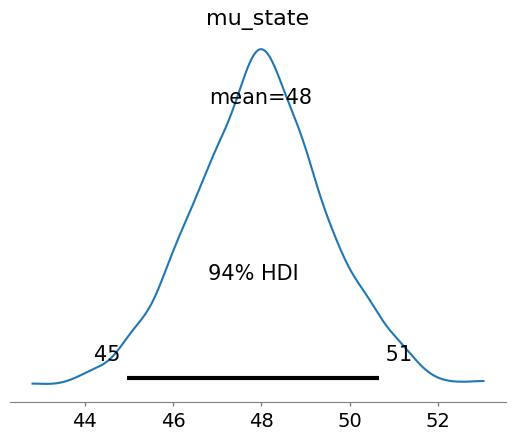

In [37]:
# Unique code of the New York state
new_york_code = grad_150_df[grad_150_df['state'] == 'New York'].iloc[0, -1]
print("New York unique code: ", new_york_code)

#  posterior distribution of the mean for the New York state
coords = {"mu_state_dim_0": new_york_code}
with pm.Model() as h_model:
    az.plot_posterior(trace_hier, var_names=["mu_state"], point_estimate='mean', coords=coords)

### Predictive distribution: New York

In order to compute the predictive distribution, for each sample of the New York posterior we need to get the mean and the standard deviation of it, and use those as sampling parameters for the predictive distribution

* For each  posterior samples $<\mu_{\text{new-york},s}, \sigma_s>$:
    * sample $y_{\text{new-york},s}^{\text{new}}$ from a normal distribution.

$$
\left[
\begin{array}{ll}
\mu_{\text{new-york},1} &   \sigma_{\text{colleges}, 1} \\
\mu_{\text{new-york},2}  & \sigma_{\text{colleges}, 2} \\
\vdots & \vdots  \\
\mu_{\text{new-york},4000}   & \sigma_{\text{colleges}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{new-york},1}^{\text{new}} \\
y_{\text{new-york},2}^{\text{new}}\\
\vdots \\
y_{\text{new-york},4000}^{\text{new}}\\
\end{array}
\right]
$$

From the summary dataframe of the predictive distribution, we can see that the minimum and maximum values of the two tails are out of the true data bounds, since the graduation rate goes from 0 to 100, but looking at the 2.5% and 97.5% percentiles, it's clearly observable that the majority of the density lies within the correct bounds, representing very well the true distribution of data, having some at the tails but the main concentration around the mean

In [38]:
post_hier = az.extract_dataset(trace_hier.posterior)

mu_new_york_hier   = post_hier.mu_state[new_york_code].values
sigma_colleges_hier  = post_hier.sigma_colleges.values

y_new_york_hier     = np.zeros(len(mu_new_york_hier))

for i, current_mu in enumerate(mu_new_york_hier):
        y_new_york_hier[i]     = np.random.normal (loc = mu_new_york_hier[i], scale = sigma_colleges_hier[i])

pd.DataFrame(y_new_york_hier).describe(percentiles=[0.025, 0.975])

<ipython-input-38-7f845c86cd98>:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_hier = az.extract_dataset(trace_hier.posterior)


,0
count,2000.000000
mean,47.778277
std,22.693957
min,-30.875277
2.5%,3.791271
50%,47.936017
97.5%,93.825485
max,120.585550


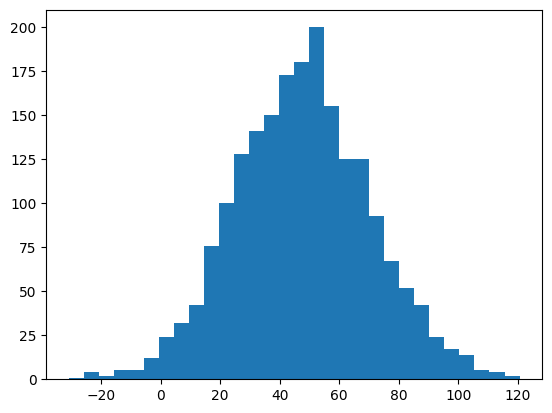

In [39]:
plt.hist(y_new_york_hier, bins=30);

### Posterior distribution of a novel group

To compute the posterior's distribution for a new group that wasn't present in our dataset, the following steps were performed:
1. Obtain the values of $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$ from the posterior trace
2. Initialize an array that will contain the new values $\mu_{\text{new}}$
3. Iterating through the values of $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$ previously stored, sample from a Normal with the current values of $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$
4. Extracts the posterior samples for the standard deviation of colleges $\sigma_{\text{grad}}$ from the hierarchical model's trace.
5. Initialize an array grad_new_college_new_state to store new college graduation rates for a new state, with the same length as the $\sigma_{\text{grad}}$ array.
6. Iterate over the $\mu_{\text{new}}$ array and for each element, sample from a normal distribution using the generated state mean $\mu_{\text{new}}$ and corresponding $\sigma_{\text{grad}}$ to generate a new college graduation rate for the new state.

While the posterior distribution for an existing state was staying within the bounds of the graduation, in this case it's more prevalent the error, showing also on the histogram below that there is not an insignificant amount of data in the out-of-bounds regions. The mean and standard deviation though are computed well with respect to the general population

In [40]:
post_hier   = az.extract(trace_hier.posterior)

mu_population    = post_hier.mu_pop.values
sigma_population = post_hier.sigma_pop.values

mu_new_state  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_state[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

sigma_colleges = post_hier.sigma_colleges.values
grad_new_college_new_state  = np.zeros(len(sigma_colleges))

for i, current_mu in enumerate(mu_population):
        grad_new_college_new_state[i] = np.random.normal (loc = mu_new_state[i], scale = sigma_colleges[i])

pd.DataFrame(grad_new_college_new_state).describe(percentiles=[0.025, 0.975])

,0
count,2000.000000
mean,40.029253
std,23.014189
min,-41.876117
2.5%,-5.460753
50%,40.690362
97.5%,84.955820
max,118.393985


(array([ 76.,  34., 108., 153., 166., 176., 175., 178., 162., 171., 124.,
        153., 165., 153., 123., 162., 150., 147., 155., 123., 132.,  91.,
         76.,  76.,  66.,  46.,  26.,  47.,  16.,  26.]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

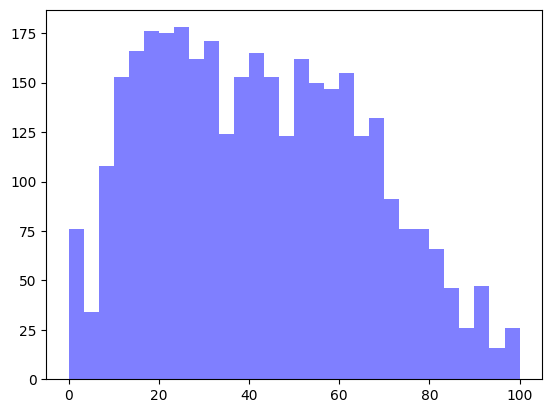

In [41]:
plt.hist(grad_150_df['grad_150_value'], bins=30, color="blue", alpha=0.5)

(array([  2.,   1.,   2.,   5.,   8.,  14.,  24.,  30.,  57.,  73.,  93.,
        148., 138., 141., 191., 178., 186., 181., 144., 110.,  90.,  64.,
         45.,  30.,  22.,  10.,   8.,   3.,   0.,   2.]),
 array([-41.87611683, -36.5337801 , -31.19144337, -25.84910664,
        -20.50676991, -15.16443318,  -9.82209645,  -4.47975972,
          0.86257701,   6.20491374,  11.54725047,  16.8895872 ,
         22.23192394,  27.57426067,  32.9165974 ,  38.25893413,
         43.60127086,  48.94360759,  54.28594432,  59.62828105,
         64.97061778,  70.31295451,  75.65529124,  80.99762797,
         86.3399647 ,  91.68230143,  97.02463816, 102.36697489,
        107.70931162, 113.05164835, 118.39398509]),
 <BarContainer object of 30 artists>)

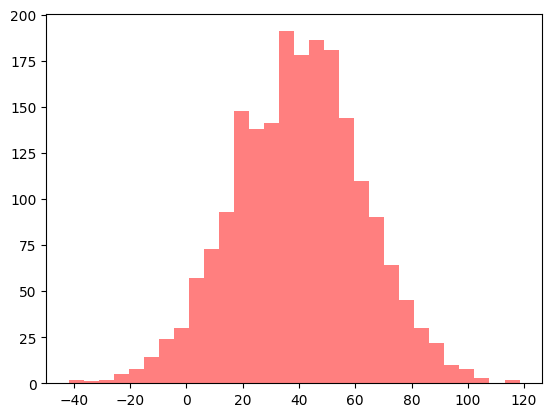

In [42]:
plt.hist(grad_new_college_new_state, bins=30, color="red", alpha=0.5)

## Probabilistic Regression model: Median SAT value to predict Graduation rate

### Variables involved
* We want to predict the value of $Y$ given the observation of $X$.

* $X$ and $Y$ are random variables:
    *  $Y$ is the *response* variable: grad_150_value
    *  $X$  is the *explanatory variable* variable: med_sat_value
* The way $Y$ is predicted is through usage of a Normal distribution that looks the following way

In [43]:
X = np.array(median_sat_values_df['med_sat_value'].values)
Y = np.array(median_sat_values_df['grad_150_value'].values)

\begin{align*}
Y &\sim N (\mu=\alpha + X \beta,  \sigma) \\
\end{align*}


*  We must specify a prior distribution for each of  parameter: $\alpha$, $\beta$, $\sigma$.
    * $\alpha$  (*intercept*):  predicted value of $Y$ for $X$ = 0; can be   seen as  a constant which calibrates the shift along the y-axis.
    * $\beta$ (*slope*):  predicted change in $Y$  for a unit change in  $X$.
    * $\sigma$ (*noise*):  noise that accounts for the variation around the regression line

### The effect of $\sigma$

* Large $\sigma$ (left): large variability of the observations around the linear model, weak relationship.

* Small $\sigma$ (right): the observations deviates  little from the  model; strong relationship.

### Regression with centered data + Choice of Priors

The regression function in case of centered data, like ours, is needed, since we know that the median SAT score is centered around a certain mean


*  *Centered* median SAT value $X$, where $\bar{x}$ is the average med_sat_value:

\begin{align*}
X_c = X - \bar{x}
\end{align*}

   
\begin{align*}
Y & = \alpha + \beta X  \\
Y & = \alpha + \beta \underbrace{(X - \bar{x})}_{X_c} + \beta \bar{x}   \\
Y & = \alpha + \beta X_c + \beta \bar{x}   \\
Y & =  \underbrace{\alpha +  \beta \bar{x}}_{\alpha_c} + \beta X_c   \\
Y & = \alpha_c + \beta X_c    \\
\end{align*}


* The intercept with centered data $\alpha_c$ is the expected value of $Y$ when $X_c = 0$ i.e., when $X = \bar{x}$.

* $\alpha_c$ is the average value of $Y$ when $X$ is at its mean.

* The meaning of $\beta$ does not change.

### Priors and Likelihood choice

Since there is no particular prior knowledge regarding this model, we're forced to go for the weakly informative data-driven approach.

*  $\alpha_c \sim N(\bar{y}, 2 s_y )$:
    * we expect $\alpha_c$  to be close to  $\bar{y}$, yet we allow large variability around it (while remaining in the same scale of the data)
    * $\bar{y}$ are the mean and the standard deviation of  $Y$ in the sample.
    

* $\beta \sim N(0, 2.5 \frac{s_y}{s_x})$
    * a priori the relation has equal probability of being increasing or decreasing; this justifies the prior mean being 0;
    * the prior is broad since in simple linear regression  $\hat{\beta} = R \frac{s_y}{s_x}$, where $R$ is the correlation between $X$ and $Y$.


*  $\sigma \sim HN (1.5 s_y)$. The prior for $\sigma$ is large compared to the standard deviation of the data, though remaining on the same scale.

* $s_x$ and $s_y$ are respectively the standard deviation of the samples from the X an Y values

### Convergence diagnostics

We setup now our PyMC model with the prior functions defined before, and run it, computing likelihood and posterior trace.

In [44]:
#implementation with data-dependent priors
x_c = (X - X.mean())
s_x = x_c.std()
s_y = Y.std()
y_bar = Y.mean()

if os.path.exists('gaussian_trace.pkl'):
    gaussian_trace = az.from_netcdf('gaussian_trace.nc')
else:
    with pm.Model() as gaussian_model:
        # Data driven priors
        alpha   = pm.Normal ('alpha', mu=y_bar, sigma=2 * s_y)
        beta    = pm.Normal ('beta',  mu=0,  sigma= 2.5 * s_y / s_x)
        sigma   = pm.HalfNormal ('sigma', sigma= 1.5 * s_y)

        # likelihood
        y_pred   = pm.Normal ('y_pred', mu= alpha + beta * x_c,  sigma=sigma, observed=Y)

        gaussian_trace   = pm.sample(idata_kwargs={"log_likelihood": True})
        az.to_netcdf(gaussian_trace, 'gaussian_trace.nc')

The model can be seen converging towards stable posterior distributions, both from the chains and from the samples, r_hat and the ess_bulk / ess_tail

In [45]:
x_bar = X.mean()
print(x_bar)
az.summary(gaussian_trace)

1061.489006823351


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,54.534,0.283,53.997,55.078,0.005,0.004,3090.0,1756.0,1.01
beta,0.112,0.002,0.108,0.116,0.000,0.000,3010.0,1412.0,1.00
sigma,10.233,0.201,9.814,10.588,0.004,0.003,2989.0,1670.0,1.00


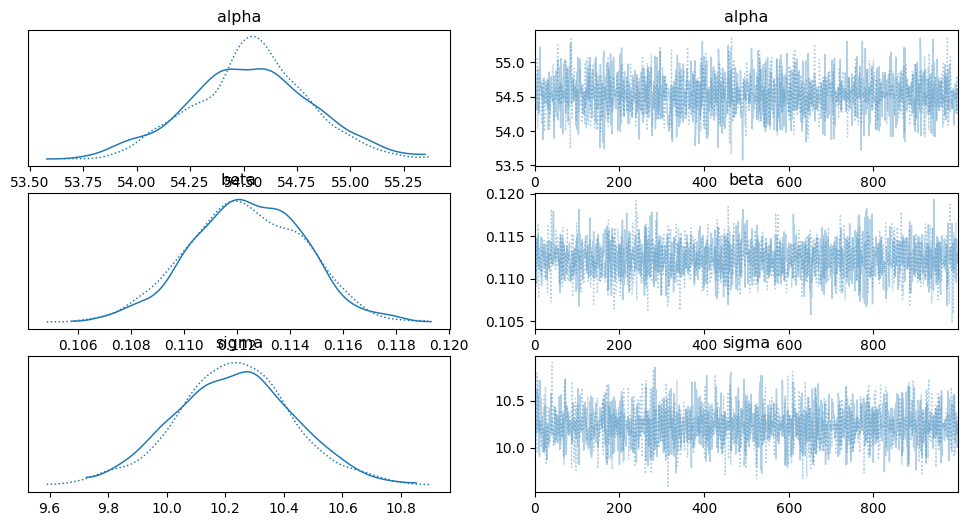

In [46]:
az.plot_trace(gaussian_trace);

Having the $\beta$ parameter as prior mean 0, and being the $\sigma$ a division of the sampling stds. of two variables X and Y, which are assumed to follow a normal distribution, we can expect there to be a very low value of standard deviation, because of which the plot shows the distribution of beta pretty far away from the 0 mean

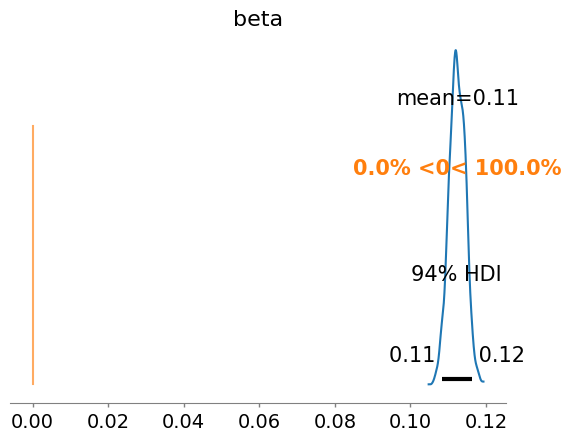

In [47]:
az.plot_posterior(gaussian_trace, var_names = "beta", ref_val=0);

Below the values of the posterior mean of alpha and beta are stored

In [48]:
#posterior mean of the parameters, gaussian model
post_gauss  = az.extract_dataset(gaussian_trace)
alpha_values = post_gauss.alpha.values
beta_values = post_gauss.beta.values
a           = alpha_values.mean()
b           = beta_values.mean()

<ipython-input-48-b83812d7b98e>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  post_gauss  = az.extract_dataset(gaussian_trace)


(array([  1.,   0.,   2.,   6.,  10.,  12.,  28.,  38.,  39.,  61.,  97.,
        124., 141., 158., 189., 181., 140., 149., 149., 146., 109.,  83.,
         46.,  40.,  18.,  11.,  13.,   5.,   2.,   2.]),
 array([0.10479787, 0.10528211, 0.10576635, 0.1062506 , 0.10673484,
        0.10721908, 0.10770332, 0.10818756, 0.1086718 , 0.10915604,
        0.10964028, 0.11012452, 0.11060876, 0.111093  , 0.11157725,
        0.11206149, 0.11254573, 0.11302997, 0.11351421, 0.11399845,
        0.11448269, 0.11496693, 0.11545117, 0.11593541, 0.11641965,
        0.11690389, 0.11738814, 0.11787238, 0.11835662, 0.11884086,
        0.1193251 ]),
 <BarContainer object of 30 artists>)

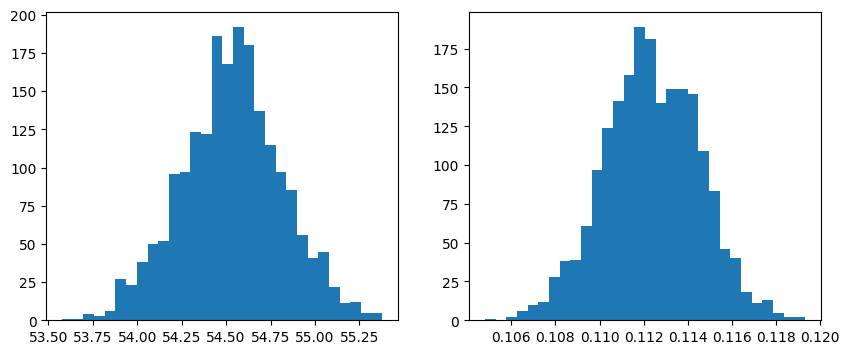

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(alpha_values, bins=30);
ax[1].hist(beta_values, bins=30);

On the plot below, it can be seen that the regression line imputed using the centered X values and the obtained alpha and beta means is very good, indeed the regression model is able to capture the two variables correlation. This plot is also very similar compared to the data exploratory part one, meaning that the model seems ulteriorly converging into a good model

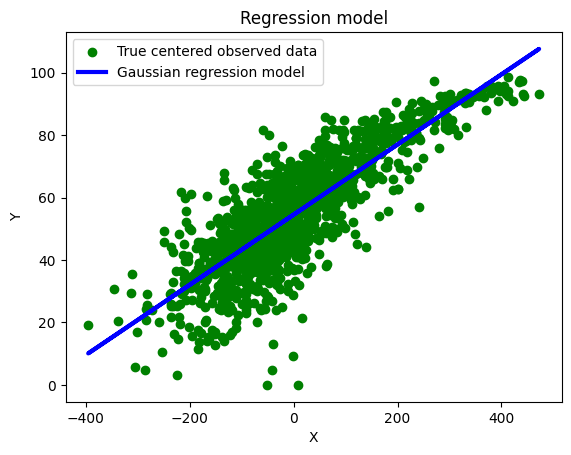

In [50]:
plt.scatter(x_c, Y, color='green', label='True centered observed data')
plt.plot(x_c,  a+ b * x_c,  color='blue', lw=3, label='Gaussian regression model')
plt.title("Regression model")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

One of the main advantages of using the bayesian regression models is to being able to account for uncertainty of the data. From this plot though, it can be seen that there is a very little presence of it, showcasing once again the strong correlation between the two variables

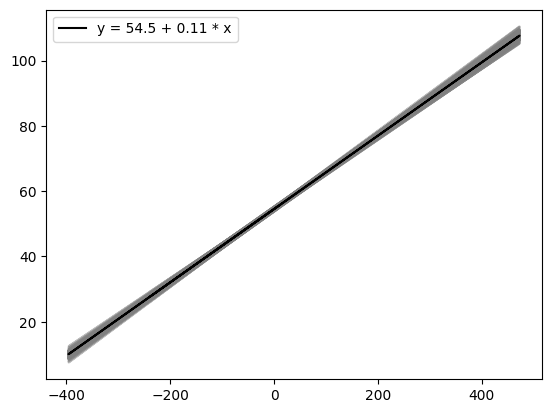

In [51]:
chosen_samples = range(0, len(alpha_values),10)

for i in range(len(chosen_samples)):
    plt.plot(x_c, post_gauss.alpha.values[i] + post_gauss.beta.values[i] * x_c, c='gray', alpha=0.5)

plt.plot(x_c, a + b * x_c, c='k',label='y = {:.1f} + {:.2f} * x'.format(a, b))
plt.legend();

### Predictive distribution for a an observation of the test set.

To understand how well our model performs when tested on data, we took a random sample from the dataset and used it to evaluate the model. The sample we got it the Adelphi University, New York. It has a median SAT value of 1098 and the corresponding rate within 150% of time of 62.5.

In [52]:
prediction_sample = median_sat_values_df.sample(1, random_state=42).iloc[0]
print(prediction_sample['chronname'], "\n\t State: ", prediction_sample['state'], "\n\t Median SAT score: ", prediction_sample['med_sat_value'], "\n\t Graduation rate within 150% of time: ", prediction_sample['grad_150_value'])

Adelphi University 
	 State:  New York 
	 Median SAT score:  1098.0 
	 Graduation rate within 150% of time:  62.5


*  Predict the graduation rate within 150% of normal time of the Adelphi University of New York?
*  The median SAT value of this college is 1098
*  First, the model we have requires we center the value before being predicted: $x^* = 1098 - \bar{x} = 1098 - 1068 = 30$

* A simple way to make predictions is to use the posterior mean of the parameters:
$$ y_{\text{pred}} = \bar{\alpha} + \bar{\beta} \cdot 30 = 54.4 + 0.11 \cdot 30 = 57.7 $$


This ignores two sources of variability:

   * the effect of the noise $\epsilon$
   * the uncertainty about the value of the  parameters

To account for parameter uncertainty, we draw a prediction for each parameter sample $<\alpha_s, \beta_s, \sigma_s>$:

$$y_{_{\text{pred},s}} \sim N(\alpha_{s} + \beta_s \cdot 30,  \sigma_s)$$

$$
\left[
\begin{array}{lll}
\alpha_{c,1} & \beta_1 & \sigma_1 \\
\alpha_{c,2} & \beta_2 & \sigma_2 \\
\vdots & \vdots & \vdots \\
\alpha_{c,4000} & \beta_{4000} & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{pred},1} \\
y_{\text{pred},2} \\
\vdots \\
y_{\text{pred},4000} \\
\end{array}
\right]
$$

In [53]:
x_test = 30

post = az.extract_dataset(gaussian_trace)

sigma_s = post.sigma.values
alpha_s = post.alpha.values
beta_s  = post.beta.values

y_test = np.zeros(shape=len(sigma_s))

preds_sample  = np.random.normal (loc = alpha_s + beta_s * x_test, scale = sigma_s)

<ipython-input-53-f7a239009069>:3: FutureWarning: extract_dataset has been deprecated, please use extract
  post = az.extract_dataset(gaussian_trace)


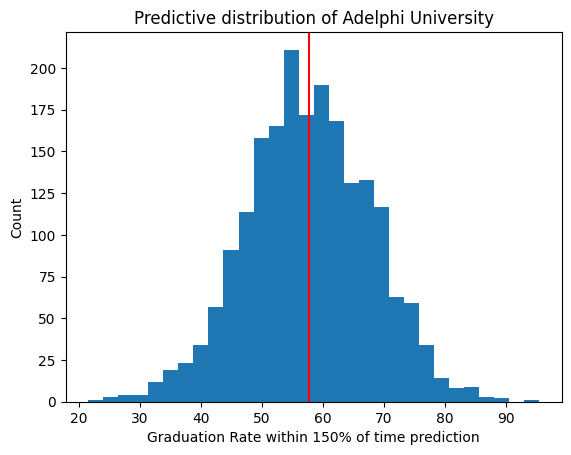

In [54]:
plt.hist(preds_sample, bins=30)
plt.axvline(preds_sample.mean(), color="red")
plt.title("Predictive distribution of Adelphi University")
plt.xlabel("Graduation Rate within 150% of time prediction")
plt.ylabel("Count");

The result of the prediction was pretty accurate with less than 5% of difference w.r.t reality. However, we decided to compute N = 50 samples in order to see what the RMSE would be. This metric would help to confirm any suspicions in quality of the model.

In [55]:
true_sample_value = round(prediction_sample['grad_150_value'], 2)
print("True value: ", true_sample_value)
results = pd.DataFrame(preds_sample).describe (percentiles=[.025, .05, .5, .95, .975])
print("Predicted value (mean of predictive distribution): ", round(results[0]['mean'], 2))

True value:  62.5
Predicted value (mean of predictive distribution):  57.7


In [56]:
n_samples = 50
rmse = 0
sampling_data_list = list()
for i in range(n_samples):
    sample = median_sat_values_df.sample(1).iloc[0]
    sampling_data = dict()
    x = sample['med_sat_value']
    y= sample['grad_150_value']

    x_test = x - x_bar

    preds  = np.random.normal (loc = alpha_s + beta_s * x_test, scale = sigma_s)
    results = pd.DataFrame(preds).describe()
    y_pred = round(float(results[0]['mean']), 2)
    residual = y_pred - y

    sampling_data['chronname'] = sample['chronname']
    sampling_data['state'] = sample['state']
    sampling_data['med_sat_value'] = sample['med_sat_value']
    sampling_data['med_sat_value_centered'] = x_test
    sampling_data['grad_150_value'] = sample['grad_150_value']
    sampling_data['grad_150_pred'] = y_pred
    sampling_data['residual'] = residual
    sampling_data_list.append(sampling_data)
    rmse += (residual)**2
rmse /= n_samples
rmse = np.sqrt(rmse)

print("RMSE for 10 samples: ", round(rmse, 4))
sampling_data_df = pd.DataFrame(data=sampling_data_list)
sampling_data_df.head()

RMSE for 10 samples:  9.2873


,chronname,state,med_sat_value,med_sat_value_centered,grad_150_value,grad_150_pred,residual
0,Mississippi Valley State University,Mississippi,825.0,-236.489007,26.0,27.69,1.69
1,Millersville University of Pennsylvania,Pennsylvania,1014.0,-47.489007,60.7,49.19,-11.51
2,Gustavus Adolphus College,Minnesota,1224.0,162.510993,82.3,72.93,-9.37
3,Lane College,Tennessee,716.0,-345.489007,30.8,15.94,-14.86
4,University of Evansville,Indiana,1147.0,85.510993,63.3,63.82,0.52


This regression model is able to predict with good accuracy the graduation rate of a college having as data its median SAT score. The two are significantly correlated and the residuals are not that big. They are smaller if the average graduation rate is approximately close to the true data mean of the graduation rate, and a little bit sparse towards the tails of the true distribution, but overall we are satisfied with the results

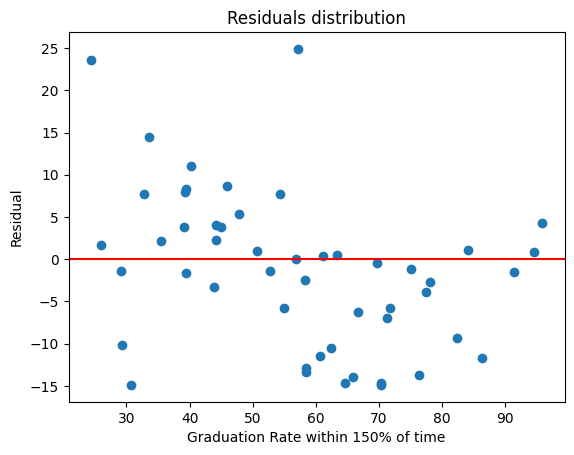

In [57]:
plt.scatter(sampling_data_df['grad_150_value'], sampling_data_df['residual'])
plt.axhline(0, color='red')
plt.title("Residuals distribution")
plt.xlabel("Graduation Rate within 150% of time")
plt.ylabel("Residual");